# Dask & multiprocessing

Computers aren't getting any _faster._

<center><img src="img/clock-rate.jpg" width="75%" /></center>

<font size="10px"><i>Computer Architecture: A Quantitative Approach,</i> David A. Patterson and John L. Hennessy</font>

But Moore's Law is still in effect: the number of transistors per square inch continues to grow exponentially (for now).

In the 21st century, however, those extra transitors are used to make more execution units, not to incrase the rate through smaller pipelines.

(The scaling of clock rates— Dennard's Law— ended because power dissipation scales with clock rate squared: anything faster than 3 GHz _cooks_ the chip!)

Most programming languages, Python among them, cannot be transparently parallelized. You'll have to change your programs to use the extra processors.

In [1]:
import numpy
import time

def prepare(height, width):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)
    return c, fractal

def run(c, fractal, maxiterations=20):
    fractal *= 0
    fractal += maxiterations
    z = c.copy()
    z2 = c.copy()
    for i in range(maxiterations):
        numpy.square(z, out=z)
        numpy.add(z, c, out=z)
        numpy.absolute(z, out=z2)
        diverge = z2 > 2
        divnow = diverge & (fractal == maxiterations)
        fractal[divnow] = i
        z[diverge] = 2
    return fractal

In [2]:
c, fractal = prepare(8000, 12000)

starttime = time.time()
fractal = run(c, fractal)
time.time() - starttime

29.426818370819092

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

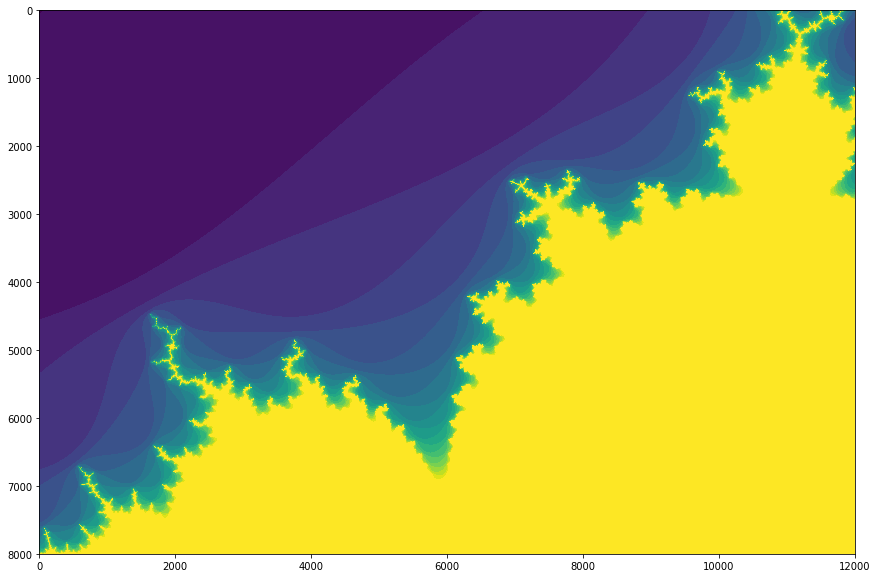

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

In [5]:
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)

In [6]:
c, fractal = prepare(8000, 12000)
# fractal = numpy.asfortranarray(fractal)

def piece(i):
    ci =       c[10*i : 10*(i + 1), :]
    fi = fractal[10*i : 10*(i + 1), :]
    run(ci, fi)

starttime = time.time()

futures = executor.map(piece, range(800))
for future in futures:         # iterating over them waits for the results
    pass

time.time() - starttime

10.699509143829346

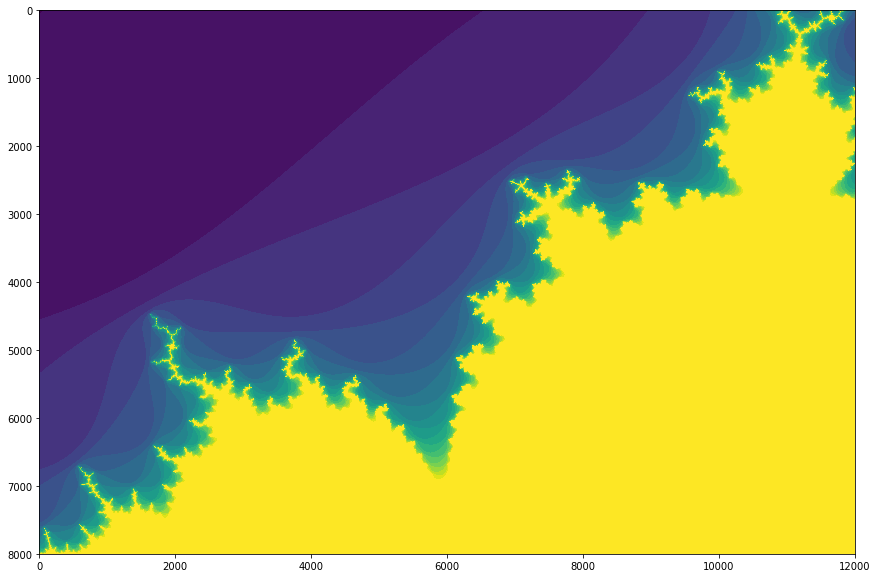

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(fractal)

In [8]:
import dask.array

In [9]:
c, fractal = prepare(8000, 12000)

c = dask.array.from_array(c, chunks=(10, 12000))
fractal = dask.array.from_array(fractal, chunks=(10, 12000))

starttime = time.time()
fractal = run(c, fractal)
time.time() - starttime

0.15981125831604004

In [10]:
fractal

dask.array<where, shape=(8000, 12000), dtype=int32, chunksize=(10, 12000)>

In [11]:
starttime = time.time()
fractal = fractal.compute()
time.time() - starttime

20.6294264793396

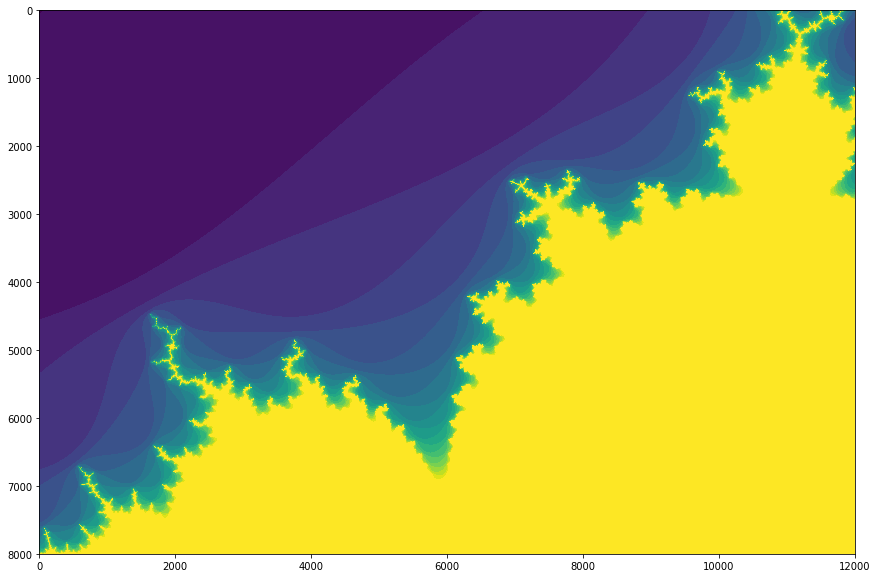

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(fractal)

In [23]:
import dask.distributed
client = dask.distributed.Client("127.0.0.1:8786")
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 12 Memory: 16.65 GB


In [24]:
c, fractal = prepare(8000, 12000)

c = dask.array.from_array(c, chunks=(100, 12000))
fractal = dask.array.from_array(fractal, chunks=(100, 12000))
fractal = run(c, fractal)

starttime = time.time()
fractal = client.compute(fractal, sync=True)
time.time() - starttime

53.0266969203949

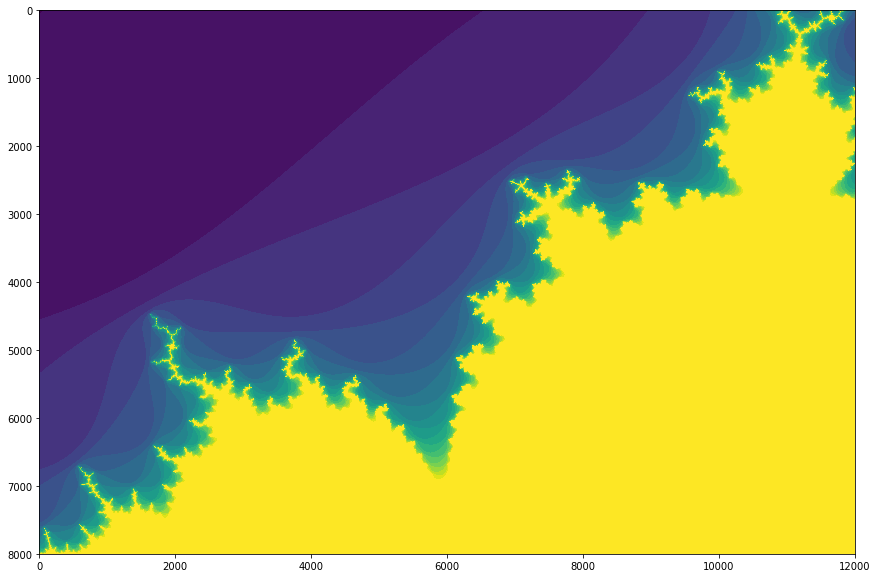

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(fractal)